### Analysis - Tri-border area
This notebook analyses the crater predictions and compares them with the THOR bombing records for the Tri-border area.
1) Main summary statistics and counts for detected craters and subset of THOR bombing records
2) Calculate correlation statistics across grid cells of different sizes
3) Create multiple Figures used in the paper

#### Input:
* *thor_path*: THOR bombing data (csv file)
* *prediction_centroids_path_sa*: Predicted bomb crater centroids for each study area (geojson files)
* *grid_path_sa*: Grid cells covering each study area for specified *grid_sizes* (geojson files)
* *vnm_gadm_path*: GADM country outlines for Vietnam (geojson file)
* *khm_gadm_path*: GADM country outlines for Cambodia (geojson file)
* *lao_gadm_path*: GADM country outlines for Lao PDR (geojson file)
* *footprint_path_sa*: KH-9 study area footprints (geojson files)
* *kh9_risk_area*: B-52 crater footprint in KH-9 imagery used for the case study (geojson file)

#### Parameters:
* *study_areas -> [study_area] -> raster_crs*: CRS of the georeferenced KH-9 images for each study area
* *study_areas -> [study_area] -> raster_date*: Date of acquisition for the KH-9 images of each study area
* *grid_sizes*: Grid sizes (in m) used for splitting up each study area into grid cells
* *crater_classes*: Names of the crater classes
* *crater_class_colors*: Color used for visualising the crater classes of detected bomb craters 
* *crater_color*: Color used for visualising the detected bomb craters
* *thor_color*: Color used for visualising the THOR bombing targets
* *fontsize*: Fontsize of the figure  
* *dpi*: DPI to use when saving the figure

#### Outputs
* *plots_folder_sa*: Folder to save the figures for each study area
* *corr_table_path*: Path to save the results of the correlation anlaysis betwen THOR and detected craters

#### Created paper content:
* **Number of predicted craters**
* **Number of predicted craters by crater class**
* **Number of bombs dropped for different subsets of the bombing records**
* **Percentage of risk area based on KH-9 imagery compared to THOR**
* **Figure 1b**: Tri-border area - Overview
* **Figure 6**: Correlations between craters and THOR bombs dropped across grid cells of different sizes
* **Figure 7**: THOR bombing vs craters on a grid
* **Figure 8**: Case study B-52 bombing missions
* **Table 2 - Tri-border area**: Correlation between THOR and detected craters across grid cells of 2km (previous year and all years)
* **Supplementary Materials - Table S5**: Correlation between THOR and detected craters across grid cells of 2km (different subsets of THOR data)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio

from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon
from rasterio.features import geometry_window
from utils import create_dir, load_config, rect_from_bound
from analysis import load_thor, process_thor

C:\Users\phili\AppData\Local\Temp\ipykernel_19736\3568971219.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
config = load_config("../config.yaml")
study_area = "tri_border_area"

In [3]:
raster_crs = config.get("study_areas").get(study_area).get("raster_crs")
footprint_path = config.get("footprint_path_sa").format(study_area=study_area)
valid_imagery_shape = (gpd.
                       read_file(footprint_path)
                       .to_crs(raster_crs))

# define parameters and data paths
output_folder = config.get("plots_folder_sa").format(study_area=study_area)
create_dir(output_folder) # create output folder if it does not exist yet
raster_crs = config.get("study_areas").get(study_area).get("raster_crs")
crater_classes = config.get("crater_classes")
crater_class_colors = config.get("crater_class_colors")
crater_color = config.get("crater_color")
thor_color = config.get("thor_color")

# key parameters for the plots
FONTSIZE = config.get("fontsize")
PROJ = ccrs.epsg(raster_crs.split(":")[1])
DPI = config.get("dpi")
CM = 1/2.54 # conversion factor between inches and cm
SAVE_PARAMS = {"format": "png", "dpi": DPI, "transparent": False, "bbox_inches": "tight", "pad_inches": 0}

Directory already exists: ../outputs/plots/tri_border_area


### Load and aggregate data for each grid cell

In [4]:
# load THOR data
thor_raw = load_thor(config.get("thor_path"))

In [5]:
thor = gpd.sjoin(
    thor_raw.to_crs(valid_imagery_shape.crs),
    valid_imagery_shape,
    how="inner",
    predicate="within"
).drop("index_right", axis=1)

# process THOR data to get number of weapons dropped for multiple different statistics of interest
thor = process_thor(thor, reference_date=config.get("study_areas").get(study_area).get("raster_date"))

In [6]:
# load crater centroids
craters = gpd.read_file(config.get("prediction_centroids_path_sa").format(study_area=study_area))

In [7]:
print(f"Number of predicted craters across Quang Tri: {len(craters)}")
print("Number of predicted craters by crater type across Quang Tri:")
np.unique(craters["value"], return_counts=True)

Number of predicted craters across Quang Tri: 99241
Number of predicted craters by crater type across Quang Tri:


(array([1., 2., 3., 4., 5.]),
 array([67985,  9995,    46, 16836,  4379], dtype=int64))

## Figure 6 - Correlations across grid cells

In [8]:
def aggregate_grid(grid_path, thor, craters):
    grid = gpd.read_file(grid_path)
    grid["grid_cell"] = grid.index

    # aggregate THOR counts for each grid_agg cell
    agg_cols = {col: "sum" for col in thor.columns if "ct_" in col}
    thor_agg = (
        thor
        .to_crs(grid.crs)
        .sjoin(grid, how="right")
        .groupby("grid_cell")
        .agg(agg_cols)
    )

    # aggregate craters over each grid cell
    craters_agg = (craters.sjoin(grid, how="right"))
    craters_agg = craters_agg.groupby(["grid_cell", "value"]).agg({"value": "size"}).unstack(fill_value=0)
    craters_agg.columns = config.get("crater_classes")
    craters_agg["craters"] = craters_agg.sum(axis=1)

    # combine aggregated THOR and crater values for each grid cell and fill other grid cells with 0
    grid_agg = grid.join(thor_agg, how="left").join(craters_agg, how="left").fillna(0)

    return grid_agg

def calc_correlation_stats(grid_path, thor, craters):
    grid_agg = aggregate_grid(grid_path, thor, craters)

    # calculate spearman correlation between different crater types and THOR weapons dropped
    grid_agg_corr = grid_agg[["ct_last_year", "ct_last_3_years", "ct_all_years", "craters"]].corr("spearman")

    return grid_agg_corr.loc["craters"]

In [9]:
grid_sizes = config.get("grid_sizes")
grid_paths = [config.get("grid_path_sa").format(study_area=study_area, grid_size=grid_size) for grid_size in grid_sizes]
res_corr = [(grid_size, *calc_correlation_stats(grid_path, thor, craters)) for grid_size, grid_path in zip(grid_sizes, grid_paths)]
df_res_corr = pd.DataFrame(res_corr, columns=["grid_size", "ct_last_year", "ct_last_3_years", "ct_all_years", "craters"])

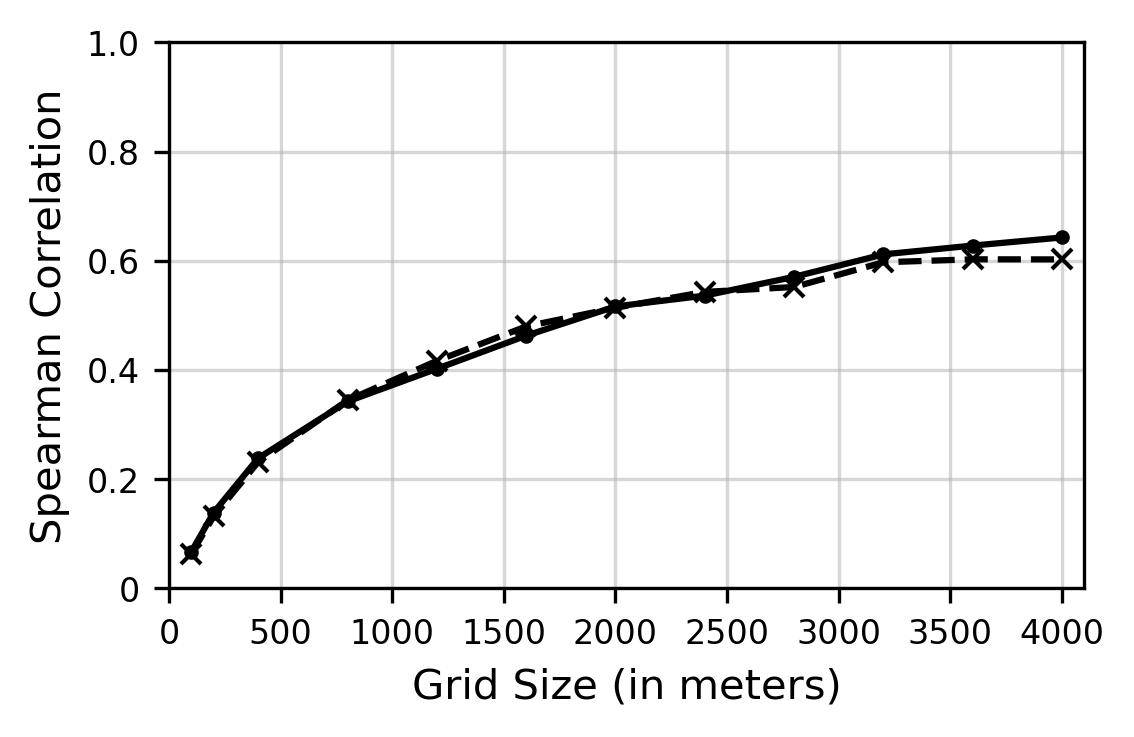

In [10]:
fig = plt.figure(figsize=(10*CM, 6*CM), dpi=DPI)

plt.plot(df_res_corr["grid_size"], df_res_corr["ct_last_year"], c="black", linestyle="dashed", marker='x', markersize=5)
plt.plot(df_res_corr["grid_size"], df_res_corr["ct_all_years"], c="black", marker='.', markersize=5)

plt.xlim([0, 4100])
plt.ylim([0, 1])

# only keep a limited amount of ticks and grid lines to avoid cluttering the plot
plt.grid(which="major", axis="x", alpha=0.5)
plt.grid(which="major", axis="y", alpha=0.5)
plt.xticks(range(0, 4500, 500), range(0, 4500, 500), fontsize=FONTSIZE)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=FONTSIZE)

plt.xlabel("Grid Size (in meters)")
plt.ylabel("Spearman Correlation")
plt.savefig(f"{output_folder}/correlation.png", **SAVE_PARAMS)

## Table 2 and Table S4 - Tri-border-area

In [11]:
# Detailed analysis for grid size of 2000 meters
grid_size_full_analysis = 2000
grid_path_full_analysis = config.get("grid_path_sa").format(study_area=study_area, grid_size=grid_size_full_analysis)
grid_agg = aggregate_grid(grid_path_full_analysis, thor, craters)
grid_agg_corr = grid_agg.drop(["grid_cell", "geometry"], axis=1).corr("spearman")
grid_agg_corr = grid_agg_corr.drop(["craters", "pattern", "rim", "group", "crescent", "bowl", "ct_last_3_years", "ct_not_last_year"], axis=0)

In [12]:
table_corr = np.round(grid_agg_corr[["craters", "pattern", "rim", "group", "crescent", "bowl"]], 2)
table_corr["num_weapons"] = thor[table_corr.index].sum()
table_corr.to_csv(config.get("corr_table_path").format(study_area=study_area))
table_corr

craters  pattern   rim  group  crescent  \
ct_all_years                         0.52     0.52  0.40   0.10      0.45   
ct_last_year                         0.51     0.53  0.42   0.11      0.47   
ct_all_years_kinetic_over200lbs      0.52     0.52  0.40   0.10      0.45   
ct_last_year_kinetic_over200lbs      0.51     0.52  0.41   0.12      0.46   
ct_all_years_kinetic_under200lbs     0.41     0.40  0.32   0.09      0.35   
ct_last_year_kinetic_under200lbs     0.34     0.34  0.29   0.13      0.29   
ct_all_years_nonkinetic              0.17     0.18  0.13   0.07      0.14   
ct_last_year_nonkinetic              0.12     0.13  0.10   0.08      0.11   
ct_all_years_weapontype_unknown      0.49     0.49  0.39   0.11      0.43   
ct_last_year_weapontype_unknown      0.50     0.50  0.40   0.12      0.44   
ct_last_year_B52_saccoact            0.43     0.44  0.38   0.07      0.40   
ct_last_year_B52_seadab              0.46     0.47  0.38   0.10      0.43   
ct_all_years_B52_saccoact            0.47     0.48  0.38   0.08      0.43   
ct_all_years_B52_seadab              0.48     0.49  0.40   0.09      0.44   

                                  bowl  num_weapons  
ct_all_years                      0.33      1133025  
ct_last_year                      0.33       321504  
ct_all_years_kinetic_over200lbs   0.34      1250068  
ct_last_year_kinetic_over200lbs   0.32       343853  
ct_all_years_kinetic_under200lbs  0.29       534798  
ct_last_year_kinetic_under200lbs  0.25       149409  
ct_all_years_nonkinetic           0.10        78338  
ct_last_year_nonkinetic           0.07         3011  
ct_all_years_weapontype_unknown   0.34       600066  
ct_last_year_weapontype_unknown   0.32       334623  
ct_last_year_B52_saccoact         0.30       220174  
ct_last_year_B52_seadab           0.31       239741  
ct_all_years_B52_saccoact         0.31       711533  
ct_all_years_B52_seadab           0.33       294806

## Spatial Figures

### Get study area extent and features

In [13]:
valid_imagery_cfeature = cfeature.ShapelyFeature(
    valid_imagery_shape.geometry,
    linewidth=1,
    facecolor="none",
    edgecolor="black",
    crs=PROJ,
)

PLOT_EXTENT = (valid_imagery_shape
               .geometry
               .buffer(2000)
               .bounds[["minx", "maxx", "miny", "maxy"]]
               .values[0])

# add inverse shape of valid imagery and the plot extent 
extent_polygon = Polygon(rect_from_bound(*PLOT_EXTENT)).buffer(100)
imagery_inv = extent_polygon.difference(valid_imagery_shape.geometry.unary_union)
IMAGERY_INV_CFEATURE = cfeature.ShapelyFeature(
    [imagery_inv],
    facecolor="white",
    edgecolor="none",
    crs=PROJ,
)

In [14]:
vietnam = gpd.read_file(config.get("vnm_gadm_path"))
vietnam = cfeature.ShapelyFeature(vietnam.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor="white")
cambodia = gpd.read_file(config.get("khm_gadm_path"))
cambodia = cfeature.ShapelyFeature(cambodia.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor="white")
lao = gpd.read_file(config.get("lao_gadm_path"))
lao = cfeature.ShapelyFeature(lao.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor="white")

pr_vnm = gpd.read_file(config.get("vnm_gadm1_path"))
kt = pr_vnm[pr_vnm["HASC_1"] == "VN.KT"]
pr_vnm = cfeature.ShapelyFeature(kt.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor="black")
pr_khm = gpd.read_file(config.get("khm_gadm1_path"))
ro = pr_khm[pr_khm["HASC_1"] == "KH.RO"]
pr_khm = cfeature.ShapelyFeature(ro.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor="black")
pr_lao = gpd.read_file(config.get("lao_gadm1_path"))
at = pr_lao[pr_lao["HASC_1"] == "LA.AT"]
pr_lao = cfeature.ShapelyFeature(at.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor="black")

In [15]:
def base_plot(figure_size, plot_background=True, add_scale=True):
    # create figure and set extent
    fig = plt.figure(figsize=(figure_size*CM, figure_size*CM), dpi=DPI)
    ax = plt.axes(projection=PROJ)
    ax.set_extent(PLOT_EXTENT, crs=PROJ)
    ax.axis("off")

    # cover up areas outside the study area and add blue outline to the plot
    ax.add_feature(IMAGERY_INV_CFEATURE, facecolor="white", zorder=3)

    if plot_background:
        ax.add_feature(valid_imagery_cfeature, facecolor="lightgrey", alpha=0.5, zorder=0)

    if add_scale:
        # add a scale bar
        scale_bar = ScaleBar(dx=1, location="lower left", color="black", box_color="none", font_properties={"family": "serif", "size": FONTSIZE})
        ax.add_artist(scale_bar)

    return fig, ax

## Figure 1b

In [16]:
pois = {
    "Dak Seang": [14.826, 107.686],
    "Dak To": [14.653, 107.794],
    "Ben Het": [14.689, 107.661],
    "Kontum": [14.356, 108.012]
}

raster_infos = list()
rasters = config.get("study_areas").get(study_area).get("rasters")
for raster_id, raster_path in rasters.items():
    src = rasterio.open(raster_path)
    img = src.read(1, out_shape=(src.height // 10, src.width // 10)) # reduce resolution for faster reading
    img[img == -32768] = np.nan
    extent = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])
    raster_infos.append([img, extent])

# set NA value of cmap to transparent (alpha=0)
cmap = plt.cm.Greys_r.copy()
cmap.set_bad("white", 0)


In [17]:
figure_size = 8

# create a slightly larger extent
overview_extent = (valid_imagery_shape
               .geometry
               .buffer(8000)
               .bounds[["minx", "maxx", "miny", "maxy"]]
               .values[0])

# add inverse shape of valid imagery and the plot extent 
overview_extent_polygon = Polygon(rect_from_bound(*overview_extent)).buffer(100)
overview_imagery_inv = overview_extent_polygon.difference(valid_imagery_shape.geometry.unary_union)
overview_imagery_inv_cfeature = cfeature.ShapelyFeature(
    [imagery_inv],
    facecolor="white",
    edgecolor="none",
    crs=PROJ,
)

# create figure and set extent
fig = plt.figure(figsize=(figure_size*CM, figure_size*CM), dpi=DPI)
ax = plt.axes(projection=PROJ)
ax.set_extent(overview_extent, crs=PROJ)
ax.axis("off")

# cover up areas outside the study area and add blue outline to the plot
ax.add_feature(overview_imagery_inv_cfeature, facecolor="white", zorder=7)
ax.add_feature(valid_imagery_cfeature, facecolor="none", edgecolor=crater_color, linewidth=1, zorder=8)

# add the KH-9 imagery as background
for img, extent in raster_infos:
    ax.imshow(img, transform=ccrs.UTM(48),
    cmap=cmap, vmin=0, vmax=255, alpha=1,
    extent=extent, zorder=3)

# add province outlines
ax.add_feature(pr_vnm, facecolor="none", edgecolor="lightgrey", linewidth=0.5, zorder=4)
ax.add_feature(pr_khm, facecolor="none", edgecolor="lightgrey", linewidth=0.5, zorder=4)
ax.add_feature(pr_lao, facecolor="none", edgecolor="lightgrey", linewidth=0.5, zorder=4)

# add country outlines
ax.add_feature(vietnam, facecolor="none", edgecolor="black", linewidth=0.5, zorder=4)
ax.add_feature(cambodia, facecolor="none", edgecolor="black", linewidth=0.5, zorder=4)
ax.add_feature(lao, facecolor="none", edgecolor="black", linewidth=0.5, zorder=4)

for name, coords in pois.items():
    ax.scatter(x=coords[1], y=coords[0], marker="o", s=4, color="black", transform=ccrs.PlateCarree(), zorder=6)

# add scale bar
scale_bar = ScaleBar(dx=1, location="lower left", color="black", box_color="none", font_properties={"family": "serif", "size": FONTSIZE})
ax.add_artist(scale_bar)
scale_bar.zorder = 10
ax.add_artist(scale_bar)

plt.savefig(f"{output_folder}/figure_1b_qt_overview.png", **SAVE_PARAMS)
plt.close()

## Craters by crater type

In [18]:
figure_size = 8
scale_factor = 0.001
scale_factor = scale_factor * figure_size**2

for i, crater_class in enumerate(crater_classes):

    fig, ax = base_plot(figure_size=figure_size, add_scale=False)

    # add crater locations
    craters_plot = craters[craters["value"] == (i+1)]
    ax.scatter(craters_plot.geometry.x, craters_plot.geometry.y,
               s=scale_factor,
               alpha=0.5,
               c=crater_class_colors[i],
               edgecolor="none",
               label="Bomb crater",
               transform=PROJ)

    plt.savefig(f"{output_folder}/{crater_class}.png", **SAVE_PARAMS)
    plt.close()

# add one plot showing all craters combined
fig, ax = base_plot(figure_size=figure_size)

craters_plot = craters
ax.scatter(craters_plot.geometry.x, craters_plot.geometry.y,
            s=scale_factor,
            alpha=0.3,
            c=crater_color,
            edgecolor="none",
            label="Bomb crater",
            transform=PROJ)

plt.savefig(f"{output_folder}/predicted_craters.png", **SAVE_PARAMS)
plt.close()

## Craters vs THOR

In [19]:
def plot_grid(figure_size, craters, thor, thor_var, craters_scale_factor, thor_scale_factor, legend_values, out_path, fontsize=FONTSIZE, grid=False, add_legend=False):
    # adjust the scale factors based on the figure size
    craters_scale_factor = craters_scale_factor * figure_size**2
    thor_scale_factor = thor_scale_factor * figure_size**2

    fig, ax = base_plot(figure_size)

    # add detected craters
    ax.scatter(craters.geometry.x, craters.geometry.y,
            s=craters_scale_factor,
            alpha=1,
            c=crater_color,
            edgecolor="none",
            label="Bomb crater",
            transform=PROJ)


    # add THOR bombing data
    if grid:
        scatter_thor = ax.scatter(thor.geometry.centroid.x, thor.geometry.centroid.y,
                s=thor[thor_var] * thor_scale_factor,
                alpha=0.8,
                c=thor_color,
                edgecolor="black",
                linewidth=0.3,
                marker="o",
                transform=ccrs.UTM(48),
                zorder=6)
        
        # add legend
        handles, labels = scatter_thor.legend_elements(
            prop="sizes",
            color=thor_color,
            markeredgecolor="black",
            linewidth=0.3,
            # as we scale prior to visualising it (see help of scatter.legend_elements)
            func = lambda x: x / thor_scale_factor, 
            fmt="{x:,.0f}",
            num=legend_values,
            alpha=1
            )
    else:
        scatter_thor = ax.scatter(thor.geometry.centroid.x, thor.geometry.centroid.y,
                s=thor[thor_var] * thor_scale_factor,
                alpha=0.8,
                c=thor_color,
                edgecolor="black",
                linewidth=0.2,
                marker="o",
                transform=ccrs.UTM(48),
                zorder=6)
        
        # add legend
        handles, labels = scatter_thor.legend_elements(
            prop="sizes",
            color=thor_color,
            markeredgecolor="black",
            linewidth=0.2,
            # as we scale prior to visualising it (see help of scatter.legend_elements)
            func = lambda x: x / thor_scale_factor, 
            fmt="{x:,.0f}",
            num=legend_values,
            alpha=1
            )

    if add_legend:
        legend = ax.legend(handles, labels, fontsize=fontsize, loc="upper right", framealpha=0).set_zorder(7)
    
    plt.savefig(out_path, **SAVE_PARAMS)

    return fig, ax

## Craters vs THOR last year

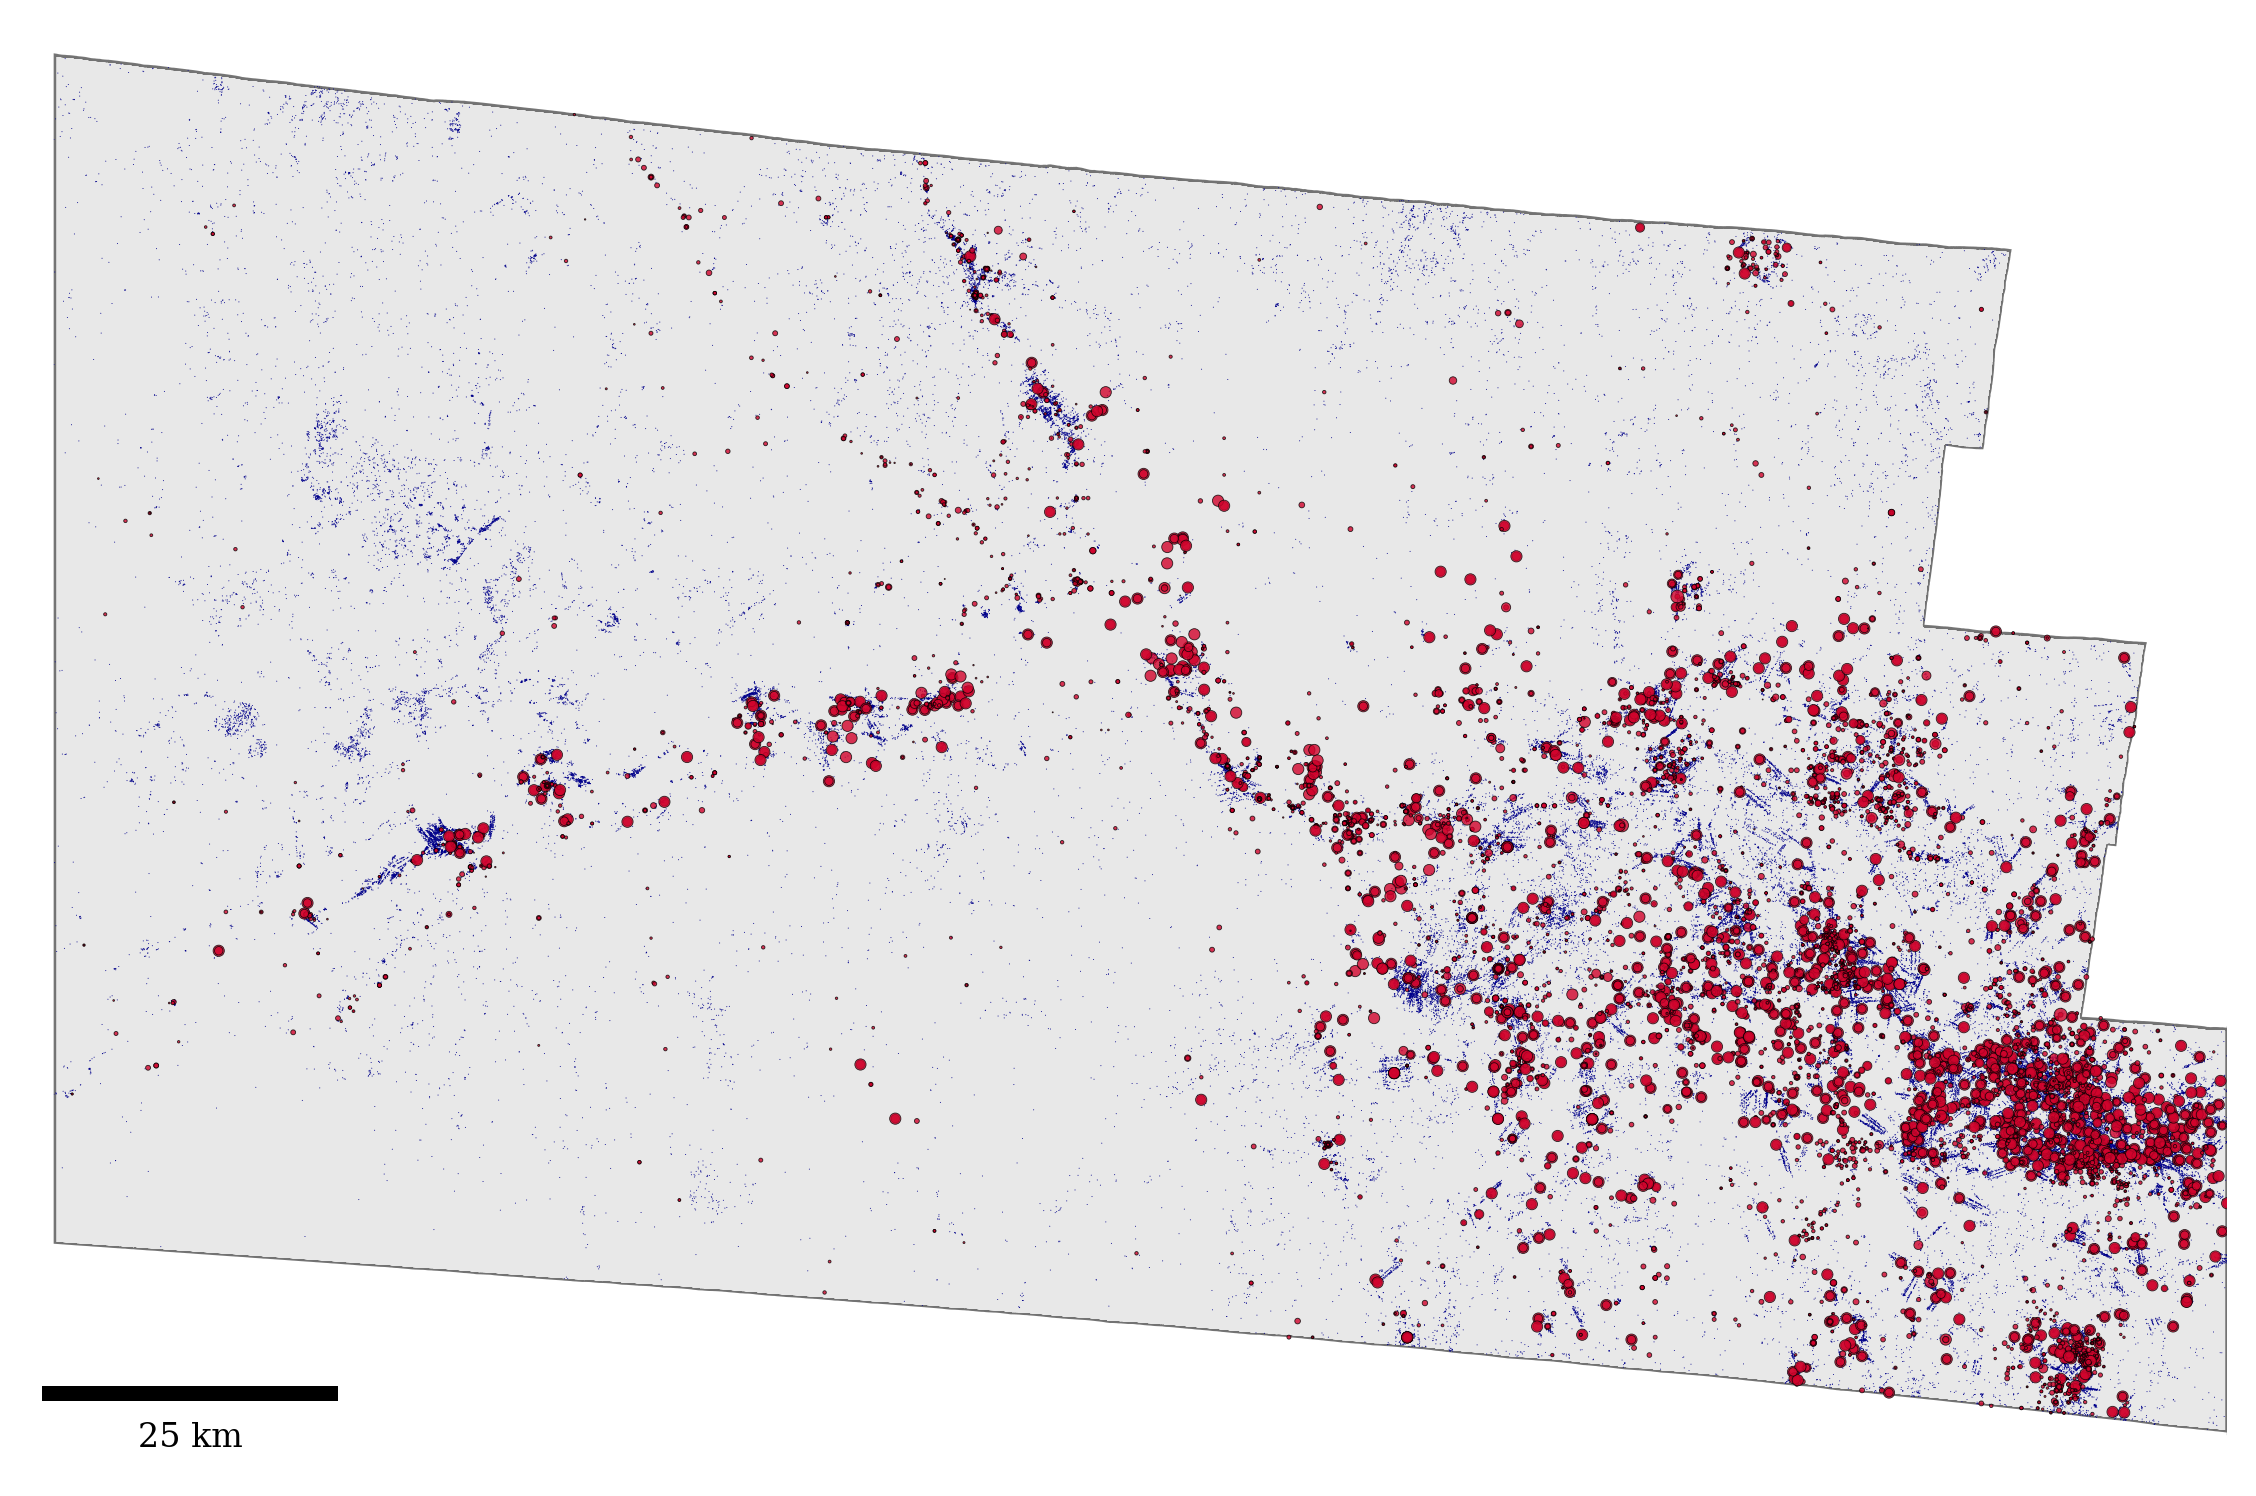

In [20]:
fig, ax = plot_grid(
    figure_size=24,
    craters=craters,
    thor=thor[thor["ct_last_year"] > 0],
    thor_var="ct_last_year",
    craters_scale_factor=0.0001,
    thor_scale_factor=0.0001,
    legend_values=[1, 72, 126, 252],
    out_path=f"{output_folder}/detailed_thor_last_year.png",
    fontsize=8
)

## Figure 7 Bombing vs Craters on a grid

In [21]:
grid_size_full_analysis = 4000
grid_path_full_analysis = config.get("grid_path_sa").format(study_area=study_area, grid_size=grid_size_full_analysis)
grid_agg = aggregate_grid(grid_path_full_analysis, thor, craters)

(<Figure size 1417.32x1417.32 with 1 Axes>, <GeoAxes: >)

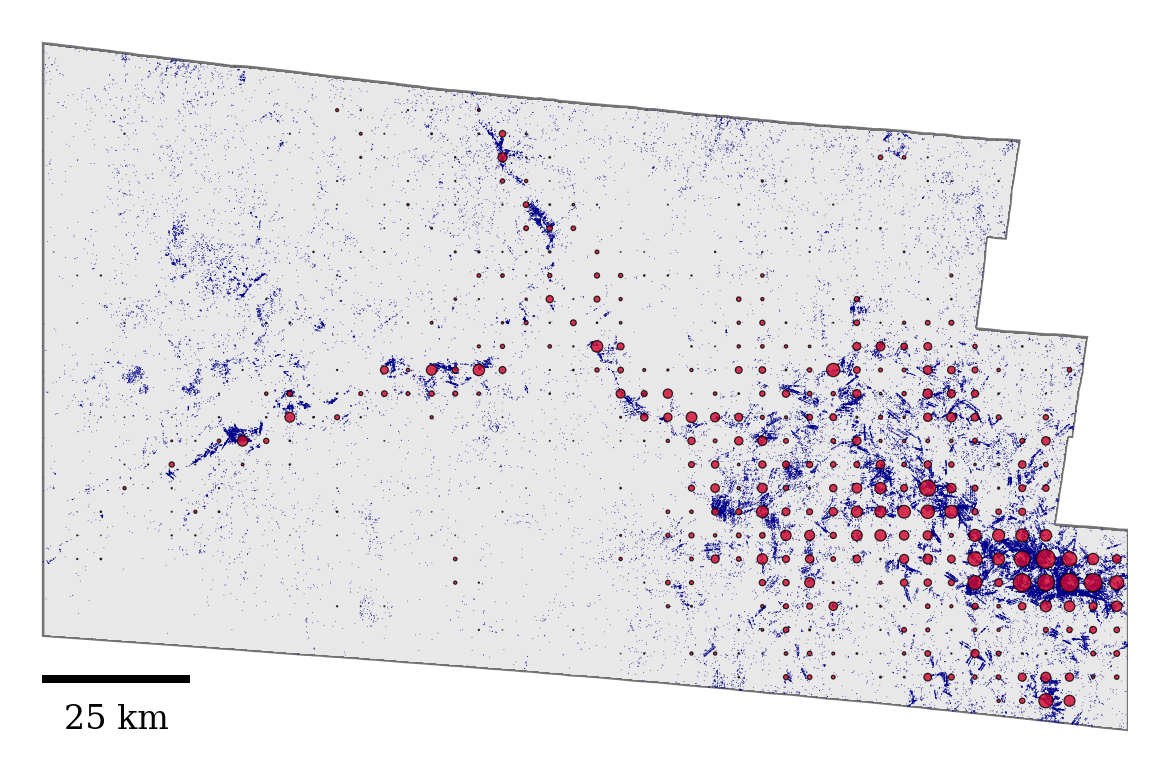

In [22]:
plot_grid(
    figure_size=12,
    craters=craters,
    thor=grid_agg,
    thor_var="ct_last_year",
    craters_scale_factor=0.00025,
    thor_scale_factor=0.00002,
    legend_values=[1000, 10000, 25000],
    out_path=f"{output_folder}/grid_last_year.png",
    grid=True,
    add_legend=False
)

(<Figure size 1417.32x1417.32 with 1 Axes>, <GeoAxes: >)

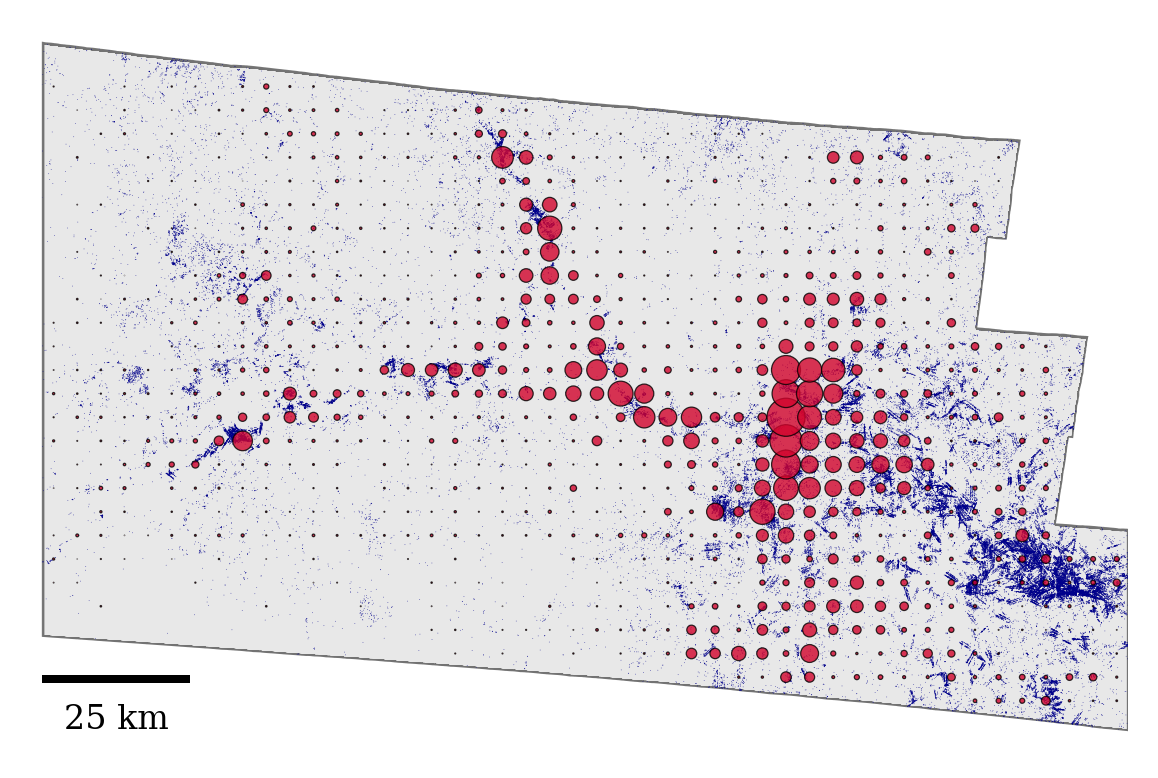

In [23]:
plot_grid(
    figure_size=12,
    craters=craters,
    thor=grid_agg,
    thor_var="ct_not_last_year",
    craters_scale_factor=0.0002,
    thor_scale_factor=0.00002,
    legend_values=[1000, 10000, 25000],
    out_path=f"{output_folder}/grid_not_last_year.png",
    grid=True,
    add_legend=False
)

## Figure 8 - Case study B-52 bombing missions

In [24]:
# define plot extent
plot_extent_case = np.array([775000, 785500, 1618000, 1626000])
plot_extent_case_poly = Polygon(rect_from_bound(*plot_extent_case))

In [25]:
# load KH-9 image for background
raster_path_A079 = config.get("study_areas").get("tri_border_area").get("rasters").get("D3C1204-200292A079")
raster_path_A080 = config.get("study_areas").get("tri_border_area").get("rasters").get("D3C1204-200292A080")

with rasterio.open(raster_path_A079) as src:
    window = geometry_window(src, [plot_extent_case_poly])
    img_A079 = src.read(1, window=window)#.astype("uint8")
    img_A079[img_A079 == -32768] = np.nan

with rasterio.open(raster_path_A080) as src:
    window = geometry_window(src, [plot_extent_case_poly])
    img_A080 = src.read(1, window=window)#.astype("uint8")
    img_A080[img_A080 == -32768] = np.nan


# set NA value of cmap to transparent (alpha=0)
cmap = plt.cm.Greys_r.copy()
cmap.set_bad("white", 0)

In [26]:
# subset THOR data to missions for the case study
thor_case = thor[(thor.within(plot_extent_case_poly)) & (thor["msndate"] > "1972-10-04") & (thor["ct_last_year"] > 0) & (thor["valid_aircraft_root"] == "B-52")].sort_values(["msndate", "timeontarget"])
thor_agg = thor_case.groupby(["tgtlonddd_ddd_wgs84", "tgtlatdd_ddd_wgs84"])["numweaponsdelivered"].sum().reset_index()

# calculate risk area around the B-52 target locations  
thor_risk_area = gpd.GeoDataFrame(
    thor_agg,
    geometry=gpd.points_from_xy(thor_agg.tgtlonddd_ddd_wgs84, thor_agg.tgtlatdd_ddd_wgs84),
    crs="EPSG:4326"
).to_crs("EPSG:32648")
thor_risk_area = thor_risk_area.buffer(2500)

In [27]:
# load polygons for risk area based on crater locations visible in KH-9 imagery (created in QGIS)
risk_area_kh9 = gpd.read_file(config.get("kh9_risk_area"))

# compare the area covered by the two risk areas
risk_area_perc = np.round(risk_area_kh9.unary_union.area / thor_risk_area.unary_union.area, 2) * 100
print(f"Percentage of risk area based on KH-9 imagery compared to THOR: {risk_area_perc}%")

Percentage of risk area based on KH-9 imagery compared to THOR: 9.0%


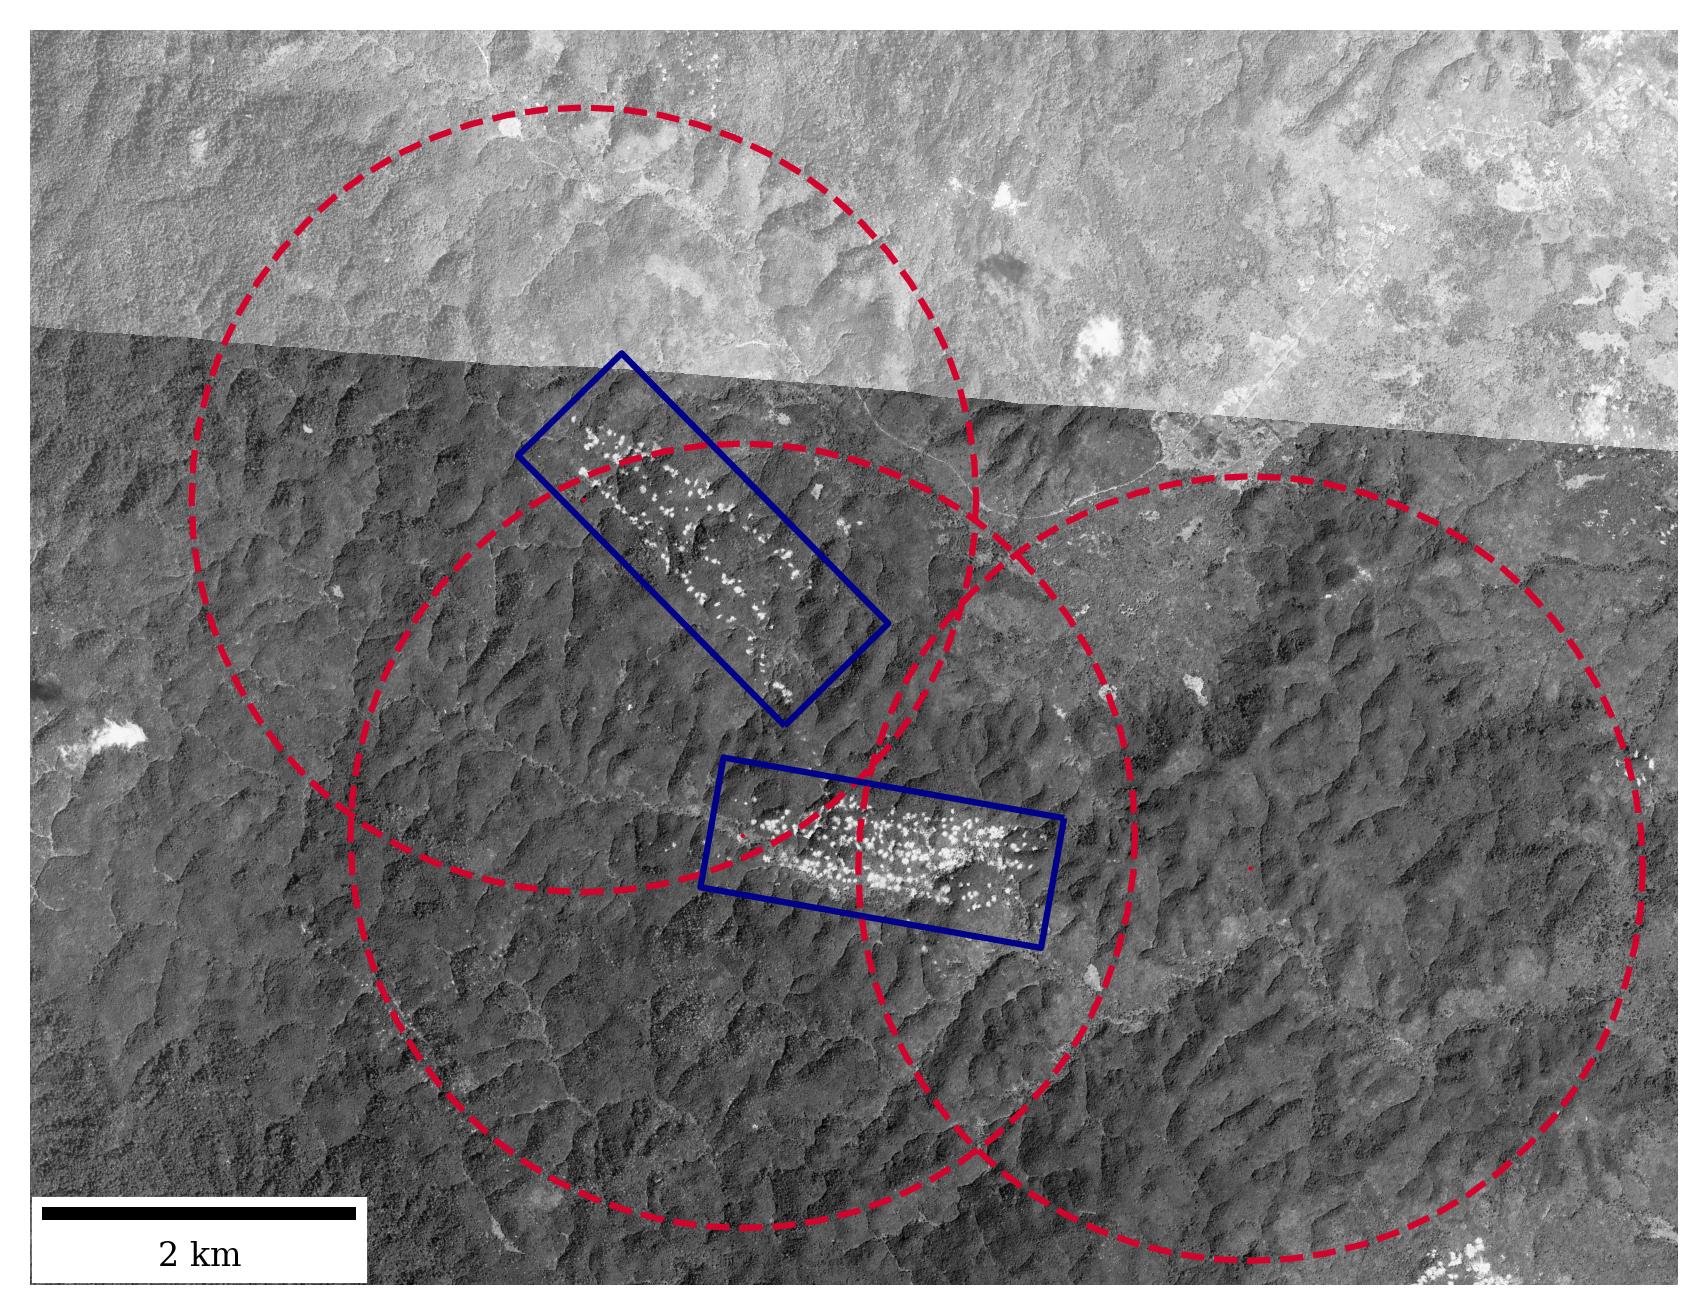

In [28]:
figure_size = 18

fig = plt.figure(figsize=(figure_size*CM, figure_size*CM), dpi=DPI)
ax = plt.axes(projection=PROJ)
ax.set_extent(plot_extent_case, crs=PROJ)
ax.axis("off")

ax.imshow(
    img_A079,
    extent=plot_extent_case,
    cmap=cmap,
    vmin=50, vmax=255,
    transform=PROJ,
    zorder=0
)

ax.imshow(
    img_A080,
    extent=plot_extent_case,
    cmap=cmap,
    vmin=50, vmax=255,
    transform=PROJ,
    zorder=0
)

ax.axis("off")

scale_bar = ScaleBar(dx=1, location="lower left", color="black", box_color="#FFFFFF", font_properties={"family": "serif", "size": FONTSIZE})
ax.add_artist(scale_bar)


scatter = ax.scatter(thor_agg.tgtlonddd_ddd_wgs84, thor_agg.tgtlatdd_ddd_wgs84,
           s=1,
           alpha=1,
           c=thor_color,
           edgecolor="none",
           transform=ccrs.PlateCarree())

thor_risk_area.plot(ax=ax, edgecolor=thor_color, color="none", linewidth=1.5, linestyle="dashed")
risk_area_kh9.plot(ax=ax, edgecolor=crater_color, color="none", linewidth=1.5, linestyle="solid")

plt.savefig(f"{output_folder}/case_study_b52.png", **SAVE_PARAMS)